# A regularized network toy example


In [1]:
import copy
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import rankdata

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, LinearRegression
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from research.pytorch.utils import RegularizedModule

In [3]:
X = np.random.normal(0, 1, size=(1000, 3)).cumsum(axis=0)
X = 2 * rankdata(X, axis=0) / (X.shape[0] + 1) - 1

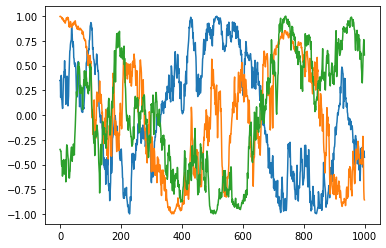

In [4]:
plt.plot(X);

In [5]:
y = 1.5 * X[:, 1] + 2*X[:, 0]**2

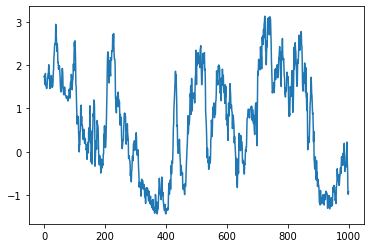

In [6]:
plt.plot(y);

In [7]:
X = np.hstack([X, X, X**2, X**2])

In [8]:
lasso = LassoCV(cv=2, random_state=0).fit(X, y)

In [9]:
regrs = LinearRegression().fit(X, y)

In [10]:
class RegPytorch(RegularizedModule):
    def __init__(self, nb_features):
        super(RegPytorch, self).__init__()
        self.layer = torch.nn.Linear(nb_features, 1)

    def forward(self, x):
        out = self.layer(x)
        return torch.squeeze(out)

In [11]:
class Data(Dataset):

    def __init__(self, X, y):

        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
        self.size = len(y)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [12]:
bs = 3

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.5)

train_loader = DataLoader(Data(X_train, y_train), batch_size=bs)
valid_loader = DataLoader(Data(X_test, y_test), batch_size=bs)

In [14]:
def train(gamma, model):
    losses = []
    model.train()
    running_loss = 0
    gradients = []
    weights = []
    valid_checks = []
    for epoch in range(epochs):
        for batch, (X, y) in enumerate(train_loader):
            
            
            # forward prop
            pred = model(X)
            
            # loss computation
            loss = loss_function(pred, y) + model.lasso(gamma)
            
            # zero gradient
            optimizer.zero_grad()
            
            # Back prop
            loss.backward()
            
            # Storing weights and gradients
            weights.append(model.layer.weight.detach().numpy().copy())
            gradients.append(model.layer.weight.grad.mean())
            
            # Update params
            optimizer.step()
            
            running_loss += loss.item()
 
        running_loss /= (batch + 1)
        losses.append(running_loss)
        valid_checks.append(valid(gamma, model))
    return losses, valid_checks,  gradients, weights


def valid(gamma, model):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(valid_loader):
            pred = model(X)
            loss = loss_function(pred, y)
            
            running_loss += loss.item()
        running_loss /= (batch + 1)
    return running_loss

## Using a Neural network without regularization

In [15]:
epochs = 80

model1 = RegPytorch(X.shape[1])
optimizer = torch.optim.Adam(params=model1.parameters(), lr=1e-3)
loss_function = torch.nn.MSELoss()
loss, valid_loss, gradients, weights = train(0, model1)

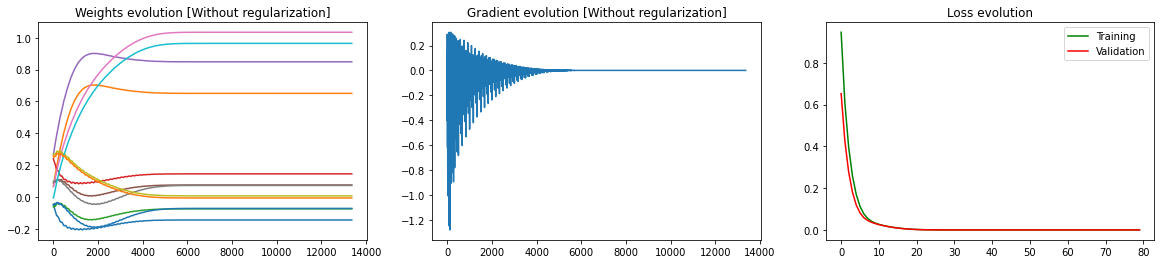

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[20, 4])

weights = np.stack(weights)
T, _, N = weights.shape

ax1.plot(weights.reshape(T, N));
ax1.set_title('Weights evolution [Without regularization]')

ax2.plot(gradients);
ax2.set_title('Gradient evolution [Without regularization]');

ax3.plot(loss, color='green')
ax3.plot(valid_loss, color='red')
ax3.set_title('Loss evolution');
ax3.legend(['Training', 'Validation'])

## Using a Neural network with regularization

In [17]:
epochs = 80

model2 = RegPytorch(X.shape[1])
optimizer = torch.optim.Adam(params=model2.parameters(), lr=1e-3)
loss_function = torch.nn.MSELoss()
loss, valid_loss, gradients, weights = train(lasso.alpha_, model2)

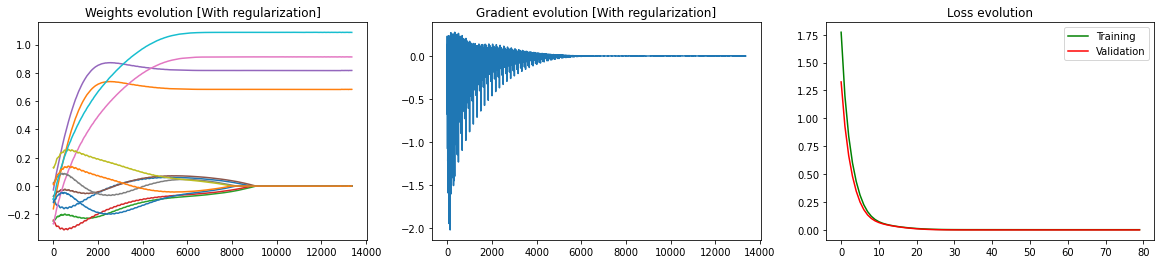

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[20, 4])

weights = np.stack(weights)
T, _, N = weights.shape

ax1.plot(weights.reshape(T, N));
ax1.set_title('Weights evolution [With regularization]')

ax2.plot(gradients);
ax2.set_title('Gradient evolution [With regularization]');

ax3.plot(loss, color='green')
ax3.plot(valid_loss, color='red')
ax3.set_title('Loss evolution');
ax3.legend(['Training', 'Validation'])

In [19]:
results = pd.DataFrame(
    [np.round(lasso.coef_, 2), 
     np.round(regrs.coef_, 4)],
    index=['Lasso', 'Regression'],
    columns=2*['X1', 'X2', 'X3'] + 2*['XX1', 'XX2', 'XX3']).T

In [20]:
results['Pytorch NN'] = model1.layer.weight.detach().numpy()[0].tolist()
results['Pytorch NN Reg'] = model2.layer.weight.detach().numpy()[0].tolist()

In [21]:
results.round(2).replace(0, np.nan).sort_index()

,Lasso,Regression,Pytorch NN,Pytorch NN Reg
X1,NaN,NaN,-0.14,NaN
X1,NaN,NaN,0.14,NaN
X2,1.50,0.27,0.65,0.68
X2,NaN,1.23,0.85,0.82
X3,NaN,0.02,-0.07,NaN
X3,NaN,-0.02,0.07,NaN
XX1,1.98,0.99,1.03,0.91
XX1,0.01,1.01,0.97,1.09
XX2,NaN,NaN,0.07,NaN
XX2,NaN,NaN,-0.07,NaN
